In [ ]:
# Importing the required libraries and dataset
import tensorflow as tf
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Load dataset and pre-process data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 3s 0us/step


In [ ]:
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.1)
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(y_test, num_classes = 100)

x_train = np.concatenate((x_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

x_train = x_train * 1.0/255
x_val = x_val * 1.0/255

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
result=model.fit(
    x_train,
    y_train,
    batch_size = 128,
    validation_data = (x_val, y_val),
    epochs = 100,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/100
430/430 [==============================] - 465s 1s/step - loss: 3.8232 - accuracy: 0.1553 - val_loss: 9.5322 - val_accuracy: 0.0130 - lr: 0.0010
Epoch 2/100
430/430 [==============================] - 438s 1s/step - loss: 2.5084 - accuracy: 0.3808 - val_loss: 3.8929 - val_accuracy: 0.1342 - lr: 0.0010
Epoch 3/100
430/430 [==============================] - 437s 1s/step - loss: 2.0344 - accuracy: 0.4745 - val_loss: 1.7962 - val_accuracy: 0.5336 - lr: 0.0010
Epoch 4/100
430/430 [==============================] - 437s 1s/step - loss: 1.7675 - accuracy: 0.5343 - val_loss: 1.5318 - val_accuracy: 0.5998 - lr: 0.0010
Epoch 5/100
430/430 [==============================] - 437s 1s/step - loss: 1.5947 - accuracy: 0.5712 - val_loss: 1.4115 - val_accuracy: 0.6242 - lr: 0.0010
Epoch 6/100
430/430 [==============================] - 431s 1s/step - loss: 1.4727 - accuracy: 0.5977 - val_loss: 1.3246 - val_accuracy: 0.6426 - lr: 0.0010
Epoch 7/100
430/430 [==============================] - 431

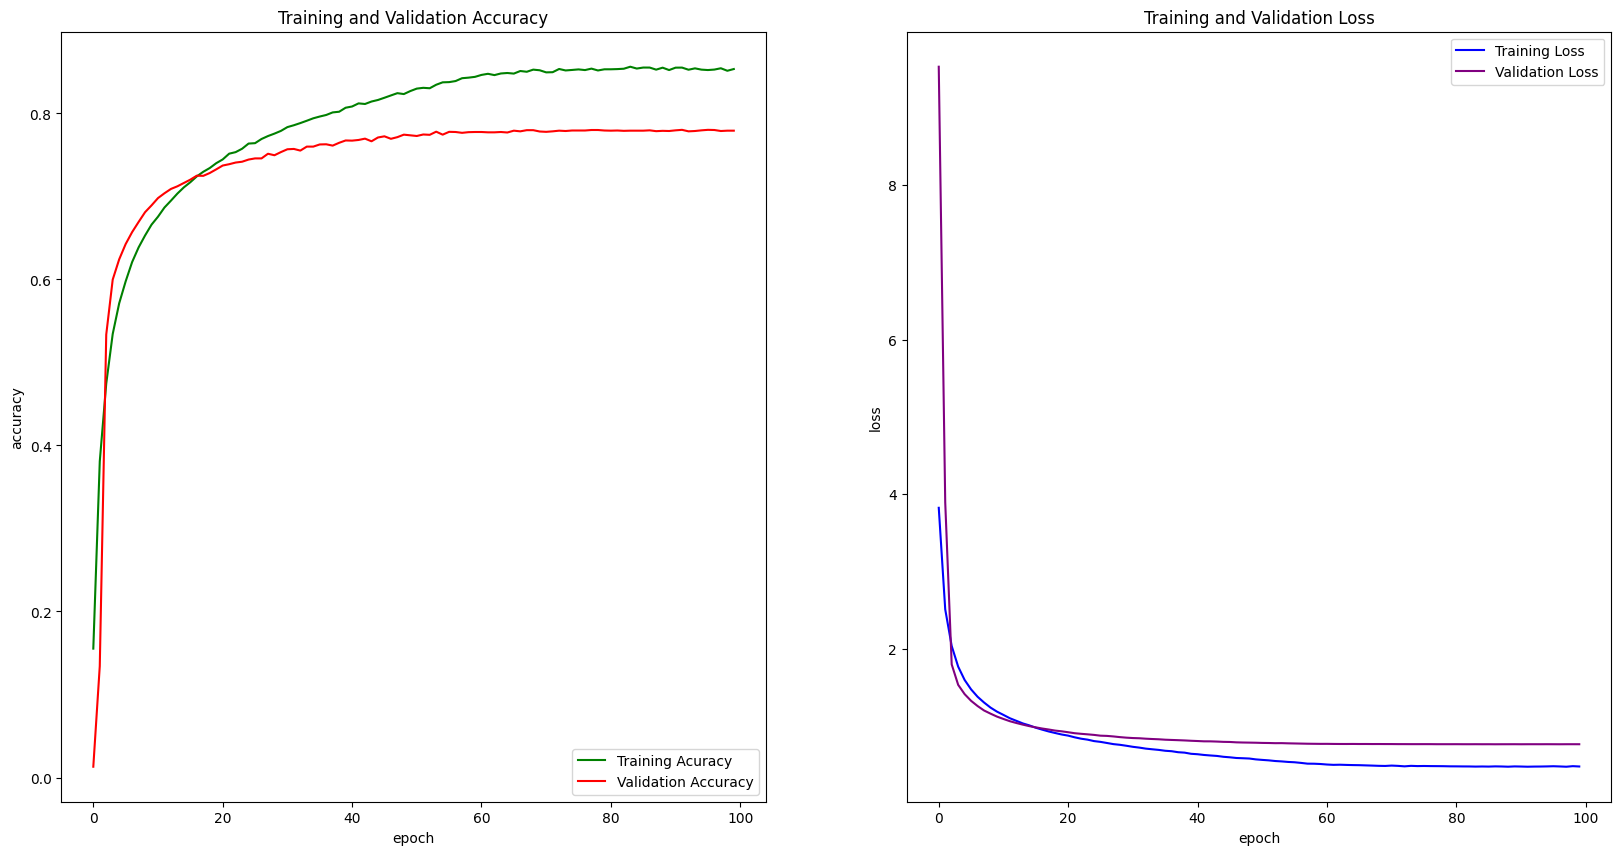

In [ ]:
plot_acc_loss(result)

In [ ]:
from google.colab import files
model.save('/content/drive/My Drive/weights/transfer_resnet50_cifar100.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
